# Exploratory Data Analysis: Infectious Disease Trends & Healthcare Utilization

This notebook performs exploratory data analysis on COVID-19 data to understand disease trends and healthcare utilization patterns across countries.

## Scenario

You are part of a multidisciplinary team working to support the United Nations Sustainable Development Goal 3: Good Health and Well-being. Your mission is to leverage data science to forecast infectious disease trends and uncover patterns in healthcare utilization across countries. By analyzing large-scale, open-access datasets, your team aims to identify disparities, forecast future outbreaks, and provide actionable recommendations for improving health outcomes globally.

Your analysis will help policymakers, public health officials, and international organizations:
- Understand which countries and regions are most at risk from infectious diseases.
- Assess how healthcare infrastructure and utilization impact disease outcomes.
- Develop data-driven strategies for resource allocation and intervention planning.
- Cluster countries based on healthcare system characteristics and disease trends to inform targeted support.
This work will contribute to global efforts in strengthening health systems, reducing inequalities, and enhancing preparedness for future public health challenges.

## 1. Setup

Import necessary libraries for data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
# Time series forecasting for COVID-19 trends
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set plot style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Load Data

Load the COVID-19 dataset and split it into train and test sets for analysis.

In [2]:
# Load the COVID-19 dataset
covid_df = pd.read_csv("../data/owid-covid-data.csv")

# Convert date to datetime
covid_df['date'] = pd.to_datetime(covid_df['date'])

# Split data into train and test sets (80% train, 20% test)
# We'll use a time-based split to maintain temporal integrity
train_cutoff_date = covid_df['date'].quantile(0.8)
train_df = covid_df[covid_df['date'] < train_cutoff_date].copy()
test_df = covid_df[covid_df['date'] >= train_cutoff_date].copy()

print(f"Training Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")
print(f"Train date range: {train_df['date'].min()} to {train_df['date'].max()}")
print(f"Test date range: {test_df['date'].min()} to {test_df['date'].max()}")

Training Data Shape: (35704, 41)
Test Data Shape: (9081, 41)
Train date range: 2019-12-31 00:00:00 to 2020-08-07 00:00:00
Test date range: 2020-08-08 00:00:00 to 2020-09-19 00:00:00


## 3. Data Overview

Examine the structure and basic statistics of the datasets.

In [3]:
# Display the first few rows of the training data
train_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
# Check data types
print("Data Types:")
train_df.dtypes

Data Types:


iso_code                                   object
continent                                  object
location                                   object
date                               datetime64[ns]
total_cases                               float64
new_cases                                 float64
new_cases_smoothed                        float64
total_deaths                              float64
new_deaths                                float64
new_deaths_smoothed                       float64
total_cases_per_million                   float64
new_cases_per_million                     float64
new_cases_smoothed_per_million            float64
total_deaths_per_million                  float64
new_deaths_per_million                    float64
new_deaths_smoothed_per_million           float64
new_tests                                 float64
total_tests                               float64
total_tests_per_thousand                  float64
new_tests_per_thousand                    float64


In [5]:
# Summary statistics for numerical columns
train_df.describe()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
count,35704,3.511000e+04,34953.000000,34171.000000,35110.000000,34953.000000,34171.000000,34889.000000,34889.000000,34106.000000,...,31565.000000,21077.000000,31970.000000,33059.000000,25296.000000,24987.000000,14702.000000,29045.000000,35054.000000,30853.000000
mean,2020-05-10 18:14:31.162894848,5.717037e+04,1092.463422,1071.829237,2841.667872,40.591423,40.427135,1201.332474,18.664151,18.314118,...,21398.107389,11.580154,250.166516,8.044918,10.935567,32.637197,53.175526,3.140980,74.197891,0.729413
min,2019-12-31 00:00:00,0.000000e+00,-2461.000000,-338.857000,0.000000,-1918.000000,-232.143000,0.000000,-265.189000,-19.206000,...,661.240000,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000,0.354000
25%,2020-04-02 00:00:00,2.400000e+01,0.000000,0.286000,0.000000,0.000000,0.000000,10.345000,0.000000,0.056000,...,5819.495000,0.500000,153.493000,5.310000,1.900000,21.400000,22.863000,1.380000,70.390000,0.612000
50%,2020-05-15 00:00:00,5.330000e+02,6.000000,9.571000,10.000000,0.000000,0.143000,183.483000,0.895000,1.971000,...,14600.861000,1.700000,237.372000,7.110000,6.434000,31.400000,55.182000,2.540000,75.800000,0.755000
75%,2020-06-26 00:00:00,5.925750e+03,113.000000,115.714000,117.000000,2.000000,2.286000,1053.774000,11.618000,12.721000,...,32605.906000,15.000000,318.949000,10.180000,19.600000,40.900000,83.741000,4.210000,80.070000,0.855000
max,2020-08-07 00:00:00,1.909244e+07,298111.000000,260432.571000,709396.000000,10491.000000,7456.714000,38906.514000,4944.376000,882.924000,...,116935.600000,77.600000,724.417000,23.360000,44.000000,78.100000,98.999000,13.800000,86.750000,0.953000
std,NaN,5.865781e+05,10129.560055,9841.608369,26892.650940,351.202504,340.269311,2849.980502,62.980333,47.160859,...,20652.971459,18.817531,118.019996,4.120566,10.496632,13.359393,31.461053,2.548989,7.321050,0.151929


## 4. Missing Values & Outliers

Identify and handle missing values and outliers in the dataset.

In [6]:
# Check missing values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in dataset:")
print(missing_values.sort_values(ascending=False))

Missing values in dataset:
new_tests_per_thousand             23464
new_tests                          23464
tests_per_case                     23207
total_tests                        23111
total_tests_per_thousand           23111
positive_rate                      22842
new_tests_smoothed_per_thousand    21991
new_tests_smoothed                 21991
tests_units                        21199
handwashing_facilities             21002
extreme_poverty                    14627
male_smokers                       10717
female_smokers                     10408
hospital_beds_per_thousand          6659
stringency_index                    5020
human_development_index             4851
aged_65_older                       4221
gdp_per_capita                      4139
aged_70_older                       3922
median_age                          3758
cardiovasc_death_rate               3734
diabetes_prevalence                 2645
population_density                  1767
new_deaths_smoothed_per_millio

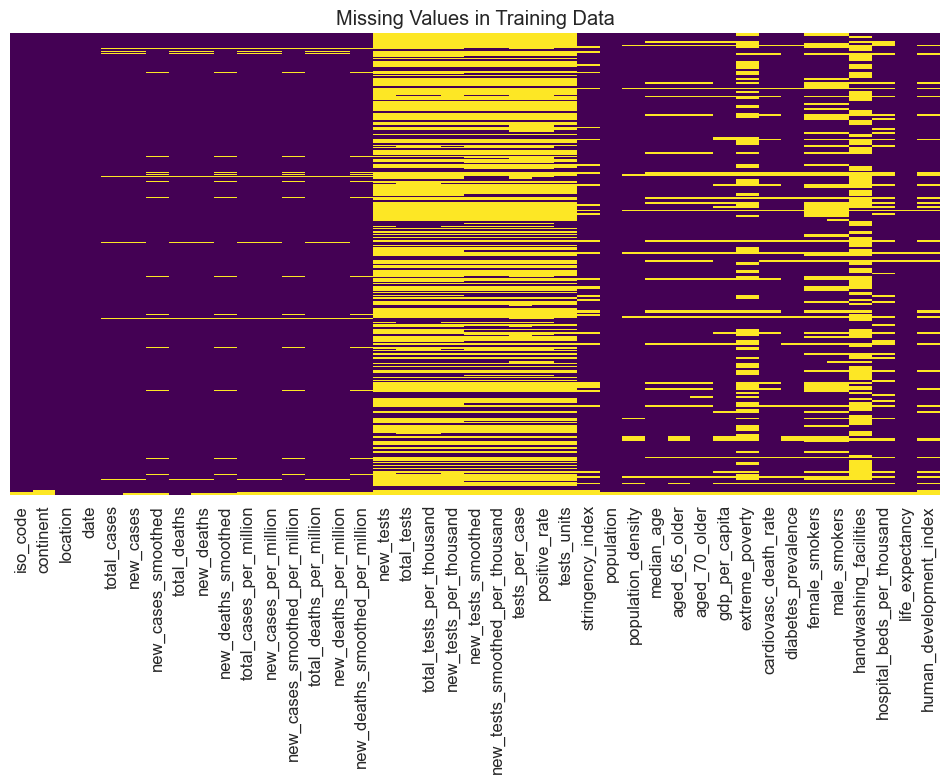

In [7]:
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values in Training Data")
plt.show()

In [8]:
# Function to detect outliers using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"{column}: {len(outliers)} outliers detected")
    return outliers

In [9]:
# Select key numerical columns for outlier detection
key_features = [
    "total_cases", "new_cases", "total_deaths", "new_deaths",
    "total_cases_per_million", "new_cases_per_million",
    "total_deaths_per_million", "new_deaths_per_million",
    "hospital_beds_per_thousand", "life_expectancy", "human_development_index"
]

# Detect outliers for all key features
outlier_dict = {}
for col in key_features:
    if col in train_df.columns:
        outlier_dict[col] = detect_outliers(train_df, col)

total_cases: 6086 outliers detected
new_cases: 6178 outliers detected
total_deaths: 6459 outliers detected
new_deaths: 6205 outliers detected
total_cases_per_million: 4771 outliers detected
new_cases_per_million: 5269 outliers detected
total_deaths_per_million: 4475 outliers detected
new_deaths_per_million: 6184 outliers detected
hospital_beds_per_thousand: 1036 outliers detected
life_expectancy: 721 outliers detected
human_development_index: 0 outliers detected


In [10]:
# Handle missing values and outliers
# For missing values in numerical columns, we'll use median imputation
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if train_df[col].isnull().sum() > 0:
        train_df[col] = train_df[col].fillna(train_df[col].median())
        test_df[col] = test_df[col].fillna(train_df[col].median())

# For missing values in categorical columns, we'll use mode imputation
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if train_df[col].isnull().sum() > 0:
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])
        test_df[col] = test_df[col].fillna(train_df[col].mode()[0])

# For outliers, we'll cap them at the 99th percentile
def cap_outliers(df, col, percentile=99):
    upper_limit = df[col].quantile(percentile / 100)
    df[col] = df[col].apply(lambda x: upper_limit if x > upper_limit else x)

# Apply capping for key features with many outliers
for col in key_features:
    if col in train_df.columns:
        cap_outliers(train_df, col, 99)
        cap_outliers(test_df, col, 99)

print("Missing values and outliers handled.")

Missing values and outliers handled.


## 5. Distributions

Analyze the distributions of key numerical and categorical variables.

### Scatterplot

At first glance, the scatterplot of healthcare capacity (total hospital beds) versus deaths per million is extremely compressed along the x-axis. This is due to a few countries having very large populations and thus much higher healthcare capacity, which skews the distribution and makes it difficult to see the patterns for most countries.

To address this, we use a log scale for the x-axis. Log scaling helps spread out the data, making it easier to observe relationships and clusters among the majority of countries, rather than having all points bunched up near the origin. This approach is especially useful when data spans several orders of magnitude, as is common with population-based metrics.

The benefit is a much clearer visualization of the relationship between healthcare capacity and COVID-19 deaths per million, allowing us to better identify trends and outliers.

### Histogram

Initially, the histogram of healthcare utilization rates (cases per hospital bed) is highly right-skewed, with most values clustered near zero and a long tail of high values. This makes it hard to interpret the distribution and compare countries.

To improve interpretability, we apply a log transformation to the healthcare utilization rates. Log transformation compresses the range of high values and spreads out the lower values, making the distribution more balanced and easier to visualize.

The benefit is a clearer understanding of the typical range of healthcare utilization rates and the ability to spot patterns or outliers that may have been hidden in the original scale.

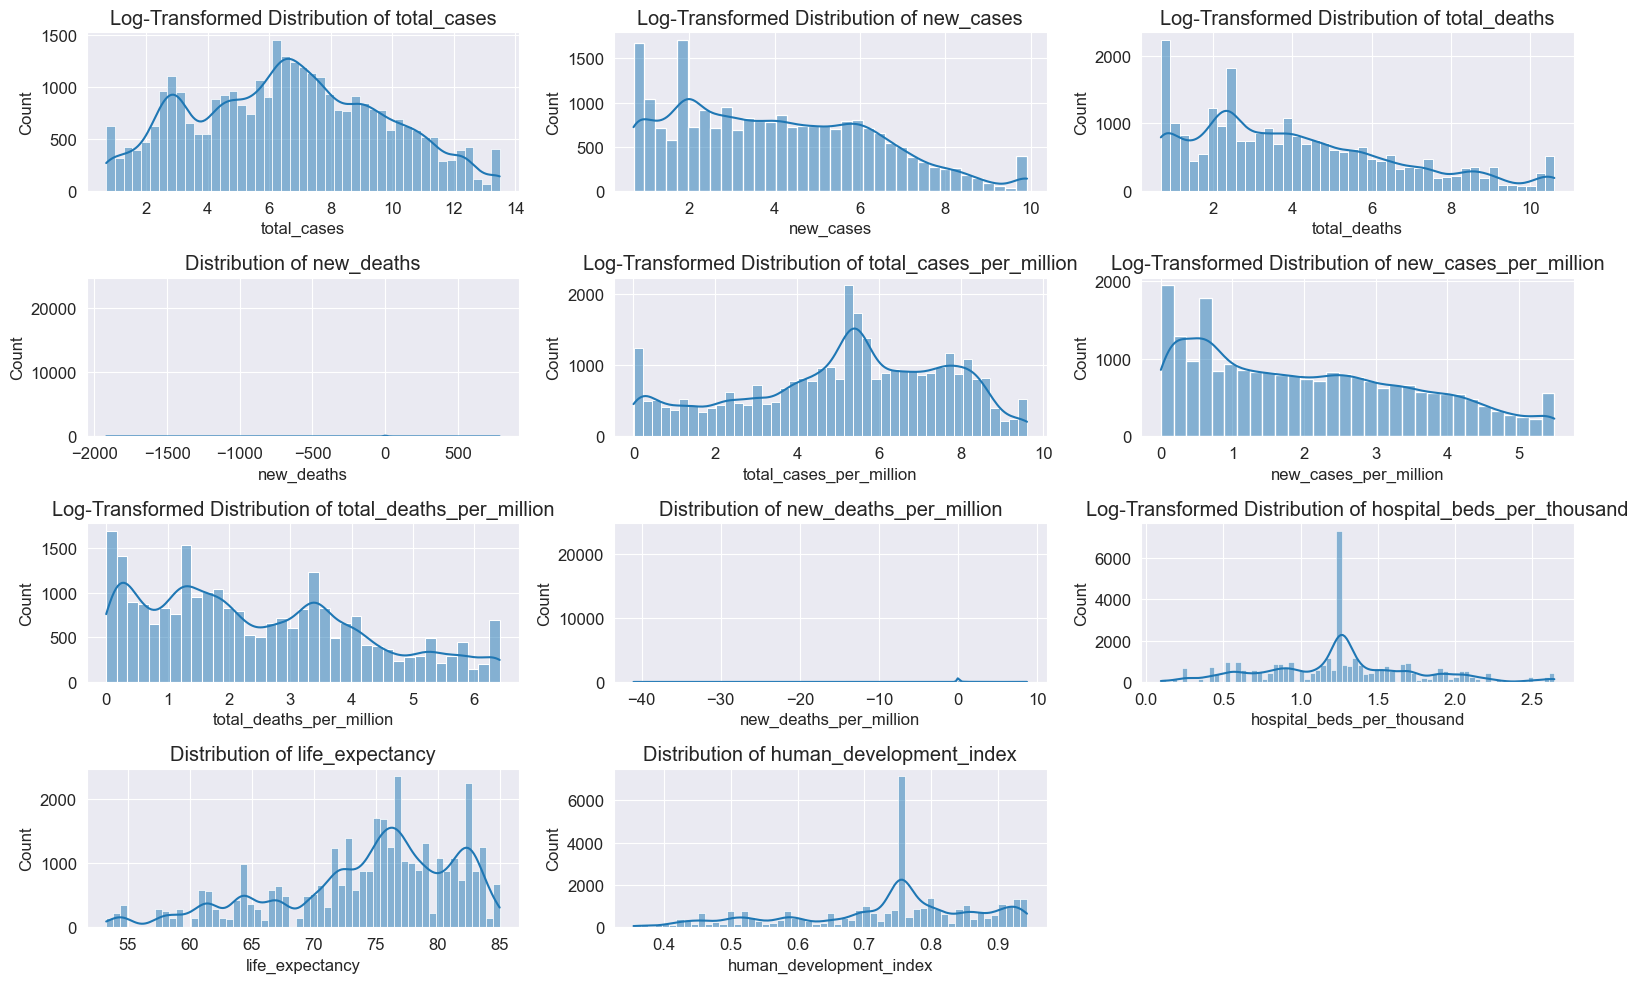

In [32]:
# Histograms for key numerical features with log transformation for skewed data
log_transform_cols = [
    "total_cases", "new_cases", "total_deaths", "total_cases_per_million",
    "new_cases_per_million", "total_deaths_per_million", "hospital_beds_per_thousand"
]
plt.figure(figsize=(16, 10))
for i, col in enumerate(key_features):
    if col in train_df.columns:
        plt.subplot(4, 3, i+1)
        data = train_df[col].dropna()
        # Apply log1p transformation for strictly positive, highly skewed features
        if col in log_transform_cols:
            data = np.log1p(data[data > 0])  # Only transform positive values
            sns.histplot(data, kde=True)
            plt.title(f"Log-Transformed Distribution of {col}")
        else:
            sns.histplot(data, kde=True)
            plt.title(f"Distribution of {col}")
        plt.tight_layout()
plt.show()

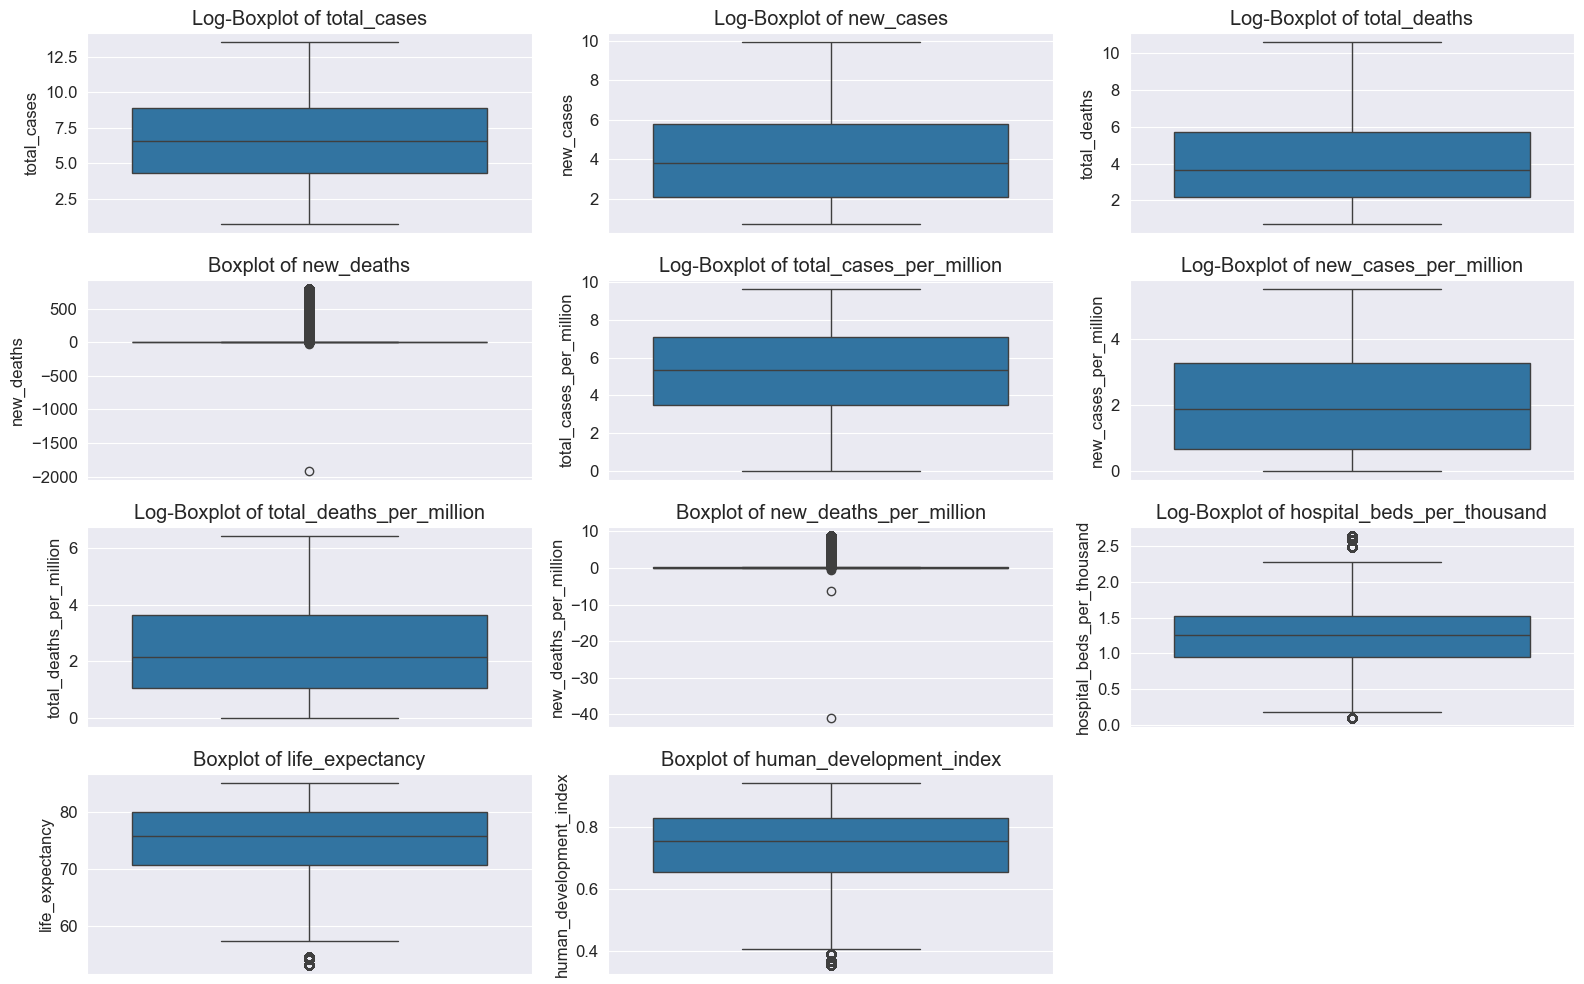

In [33]:
# Boxplots for key numerical features with log transformation for skewed data
log_transform_cols = [
    "total_cases", "new_cases", "total_deaths", "total_cases_per_million",
    "new_cases_per_million", "total_deaths_per_million", "hospital_beds_per_thousand"
]
plt.figure(figsize=(16, 10))
for i, col in enumerate(key_features):
    if col in train_df.columns:
        plt.subplot(4, 3, i+1)
        data = train_df[col].dropna()
        # Apply log1p transformation for strictly positive, highly skewed features
        if col in log_transform_cols:
            data = np.log1p(data[data > 0])  # Only transform positive values
            sns.boxplot(y=data)
            plt.title(f"Log-Boxplot of {col}")
        else:
            sns.boxplot(y=data)
            plt.title(f"Boxplot of {col}")
        plt.tight_layout()
plt.show()

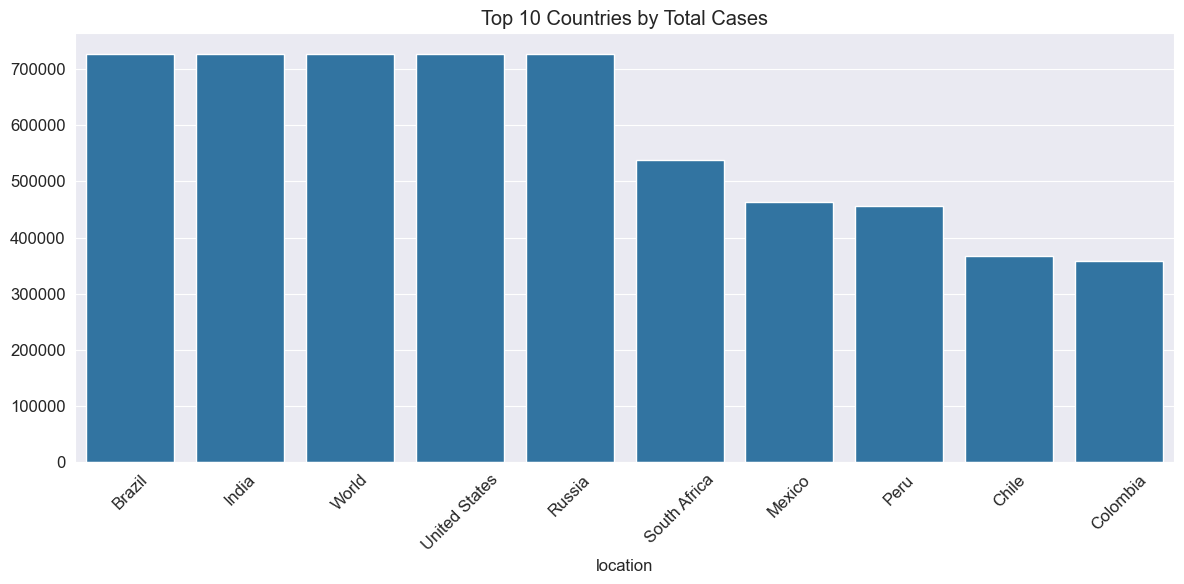

In [13]:
# Bar charts for categorical features
# Top 10 countries by total cases
top_countries = train_df.groupby('location')['total_cases'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by Total Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

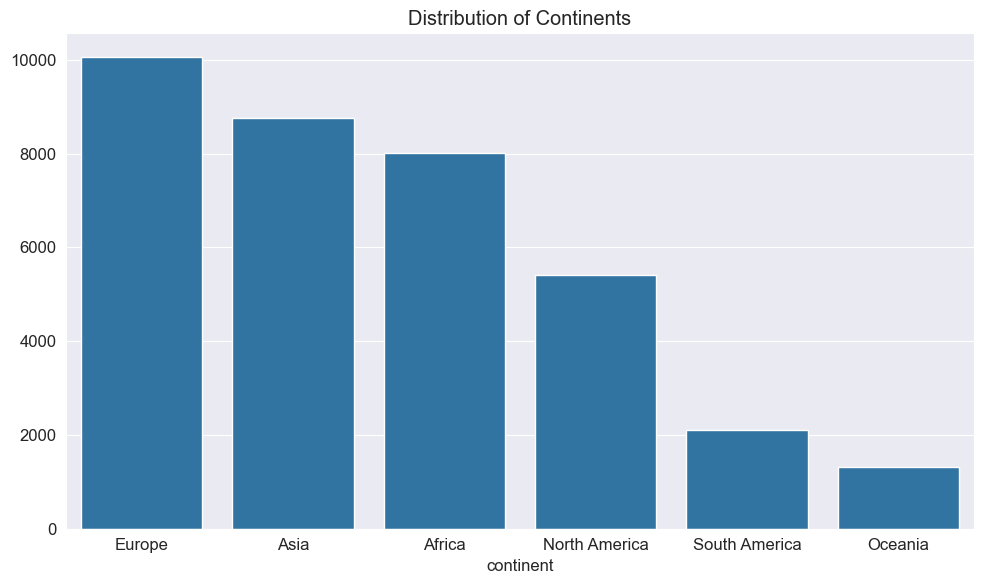

In [14]:
# Distribution of continents
continent_counts = train_df['continent'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=continent_counts.index, y=continent_counts.values)
plt.title("Distribution of Continents")
plt.tight_layout()
plt.show()

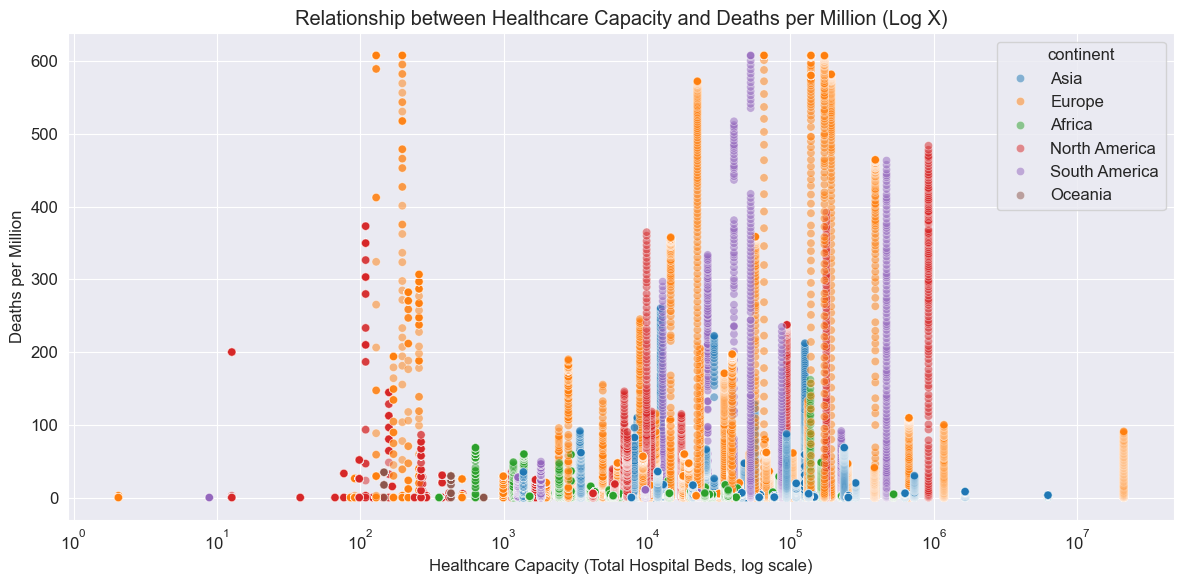

In [34]:
# Additional healthcare infrastructure analysis
# Calculate healthcare capacity metrics
train_df['healthcare_capacity'] = train_df['hospital_beds_per_thousand'] * train_df['population'] / 1000
train_df['cases_per_bed'] = train_df['total_cases'] / train_df['healthcare_capacity']

# Analyze relationship between healthcare capacity and COVID-19 outcomes
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='healthcare_capacity', 
    y='total_deaths_per_million', 
    data=train_df, 
    alpha=0.5, 
    hue='continent'
)
plt.xscale('log')  # Log scale for x-axis
plt.title("Relationship between Healthcare Capacity and Deaths per Million (Log X)")
plt.xlabel("Healthcare Capacity (Total Hospital Beds, log scale)")
plt.ylabel("Deaths per Million")
plt.tight_layout()
plt.show()



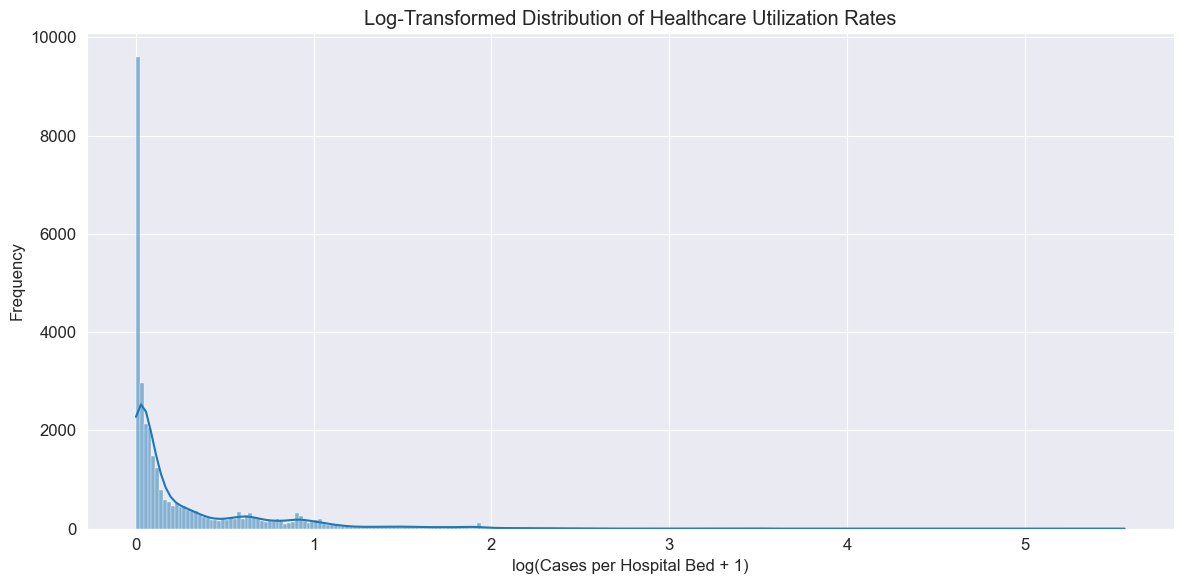

In [35]:
# Calculate and visualize healthcare utilization rates
plt.figure(figsize=(12, 6))
utilization = train_df['healthcare_utilization'].dropna()
utilization = utilization[utilization > 0]  # Only positive values for log
sns.histplot(np.log1p(utilization), kde=True)
plt.title("Log-Transformed Distribution of Healthcare Utilization Rates")
plt.xlabel("log(Cases per Hospital Bed + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## 6. Correlations & Relationships

Analyze correlations between numerical features and relationships between variables.

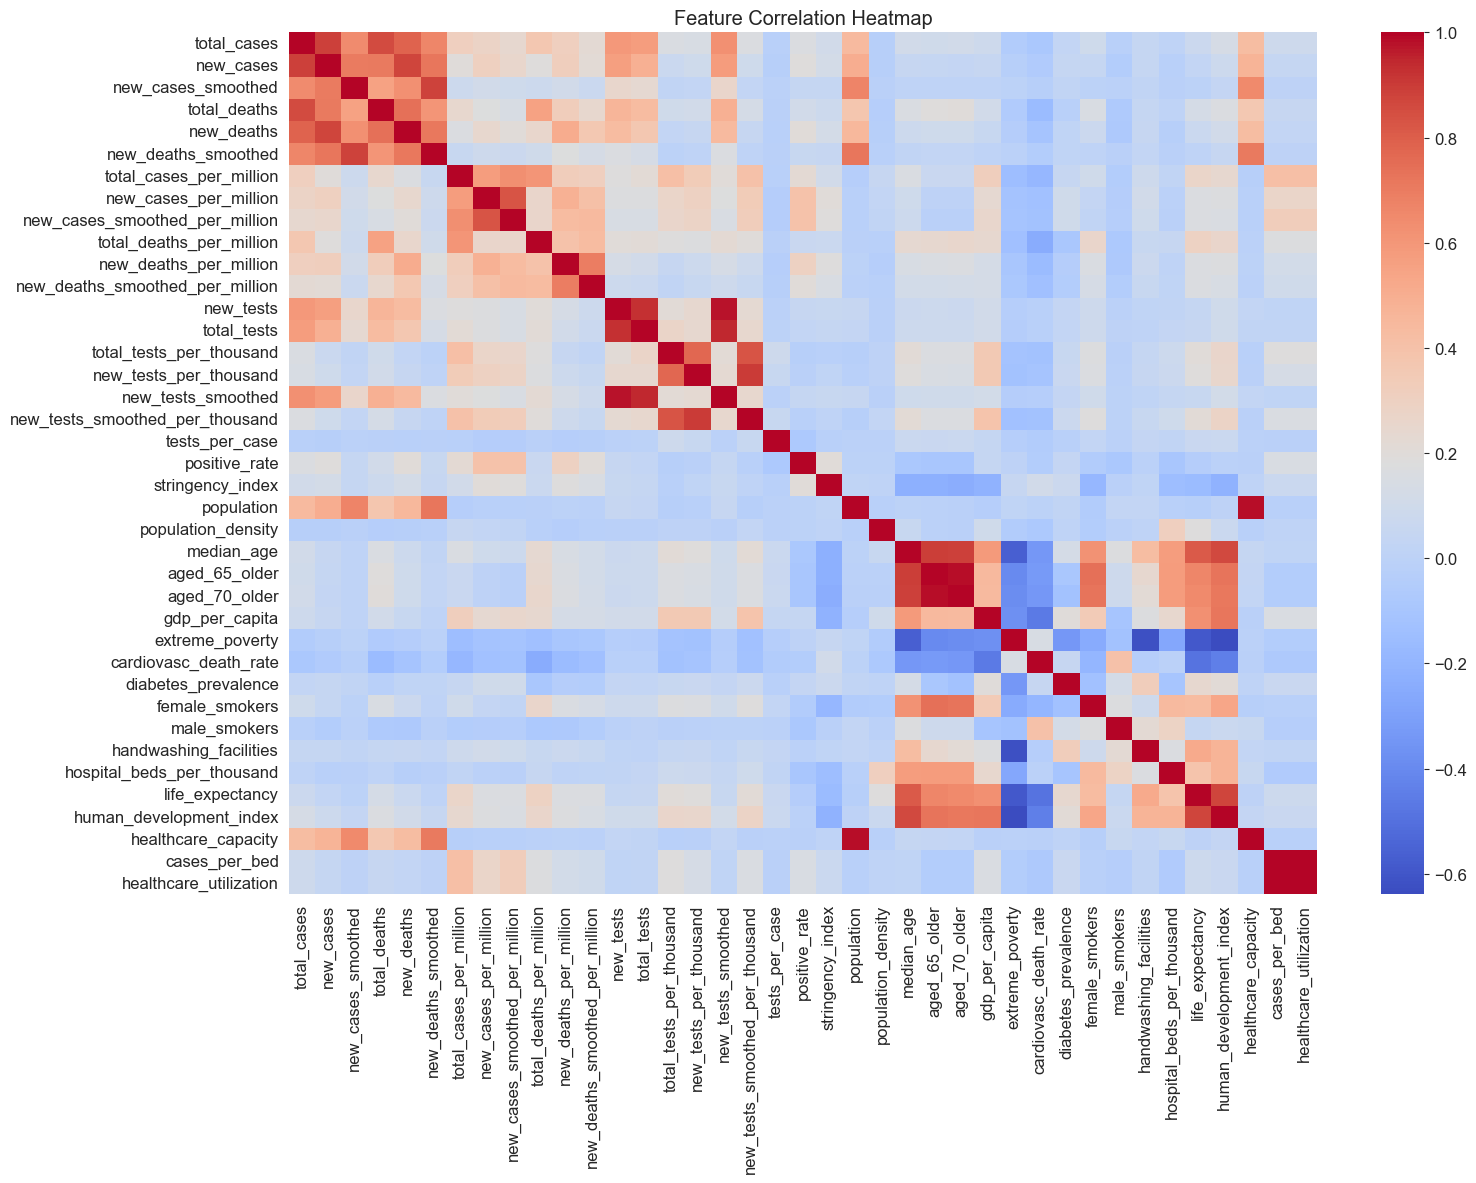

In [16]:
# Select only numerical columns for correlation analysis
numeric_df = train_df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [17]:
# Display top correlated features with total_cases
if 'total_cases' in correlation_matrix.columns:
    top_correlations = correlation_matrix["total_cases"].abs().sort_values(ascending=False)
    print("Top correlations with total_cases:")
    print(top_correlations.head(15))

Top correlations with total_cases:
total_cases                 1.000000
new_cases                   0.886229
total_deaths                0.856439
new_deaths                  0.788349
new_deaths_smoothed         0.666418
new_cases_smoothed          0.644455
new_tests_smoothed          0.624266
new_tests                   0.593008
total_tests                 0.571751
population                  0.442915
healthcare_capacity         0.426908
total_deaths_per_million    0.369012
new_deaths_per_million      0.312415
total_cases_per_million     0.309126
new_cases_per_million       0.276754
Name: total_cases, dtype: float64


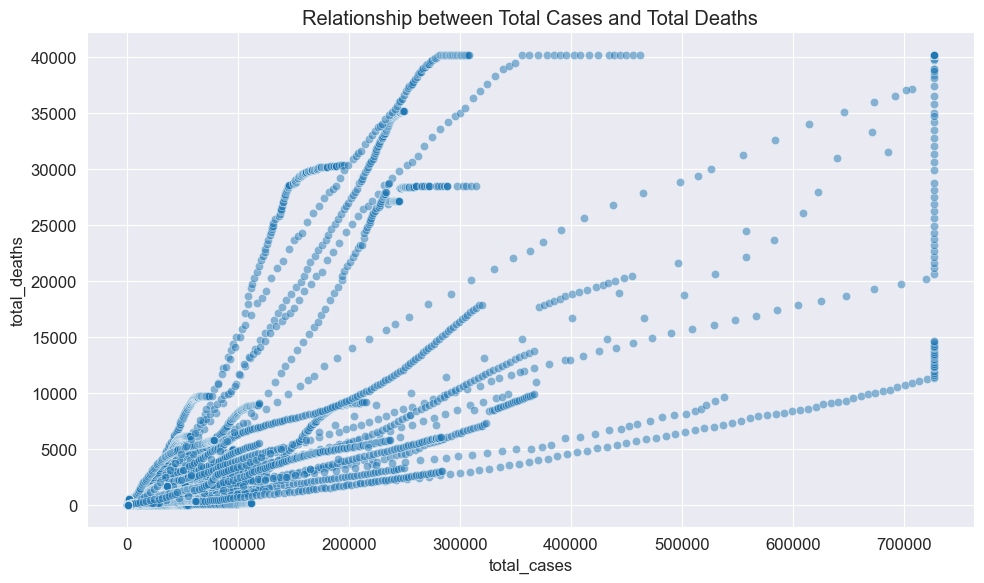

In [18]:
# Scatter plots for key relationships
# Relationship between total cases and total deaths
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_cases', y='total_deaths', data=train_df, alpha=0.5)
plt.title("Relationship between Total Cases and Total Deaths")
plt.tight_layout()
plt.show()

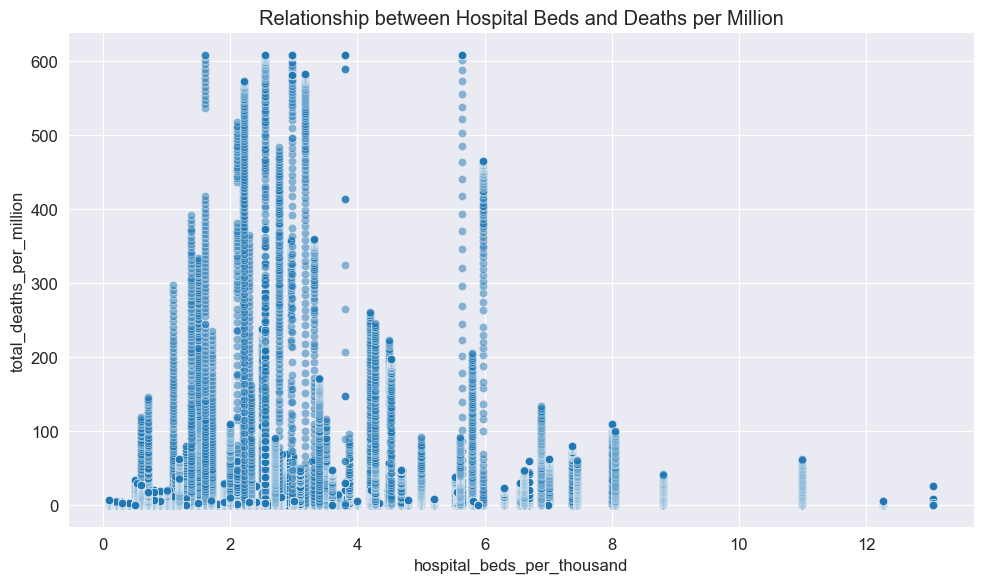

In [19]:
# Relationship between hospital beds and deaths per million
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hospital_beds_per_thousand', y='total_deaths_per_million', data=train_df, alpha=0.5)
plt.title("Relationship between Hospital Beds and Deaths per Million")
plt.tight_layout()
plt.show()

## 7. Time-Series Analysis

Analyze trends and patterns over time.

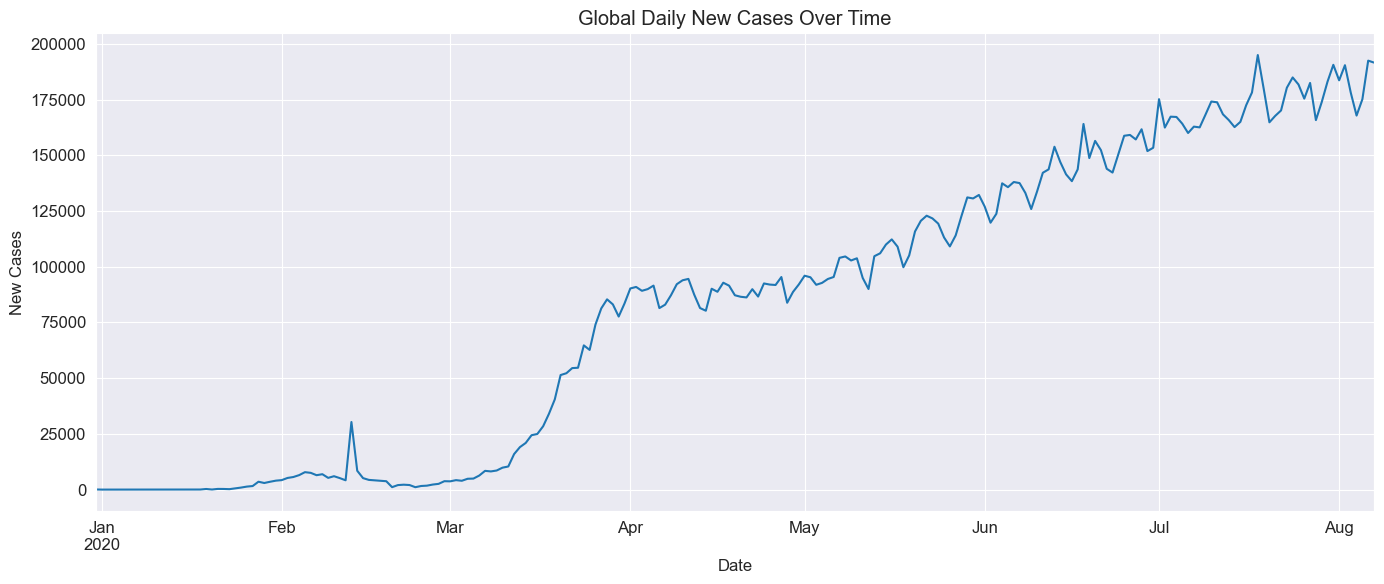

In [20]:
# Set date as index for time series analysis
train_ts = train_df.set_index('date')

# Plot global daily new cases over time
global_daily_cases = train_ts.groupby('date')['new_cases'].sum()
plt.figure(figsize=(14, 6))
global_daily_cases.plot()
plt.title("Global Daily New Cases Over Time")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.tight_layout()
plt.show()

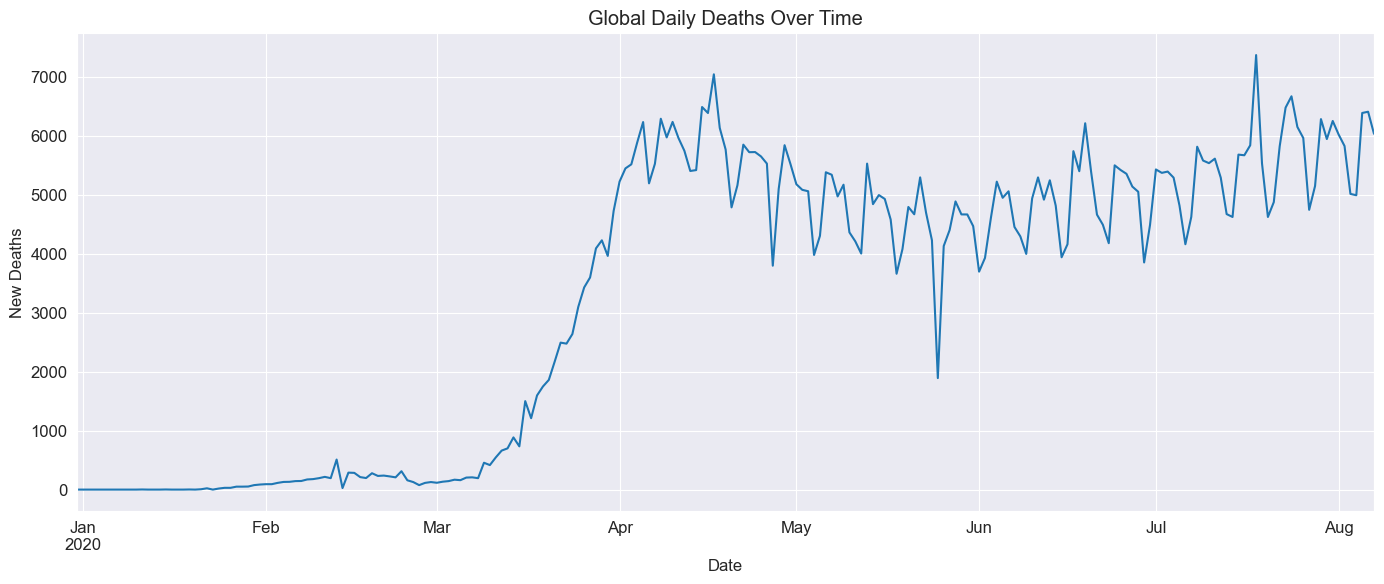

In [21]:
# Plot global daily deaths over time
global_daily_deaths = train_ts.groupby('date')['new_deaths'].sum()
plt.figure(figsize=(14, 6))
global_daily_deaths.plot()
plt.title("Global Daily Deaths Over Time")
plt.xlabel("Date")
plt.ylabel("New Deaths")
plt.tight_layout()
plt.show()

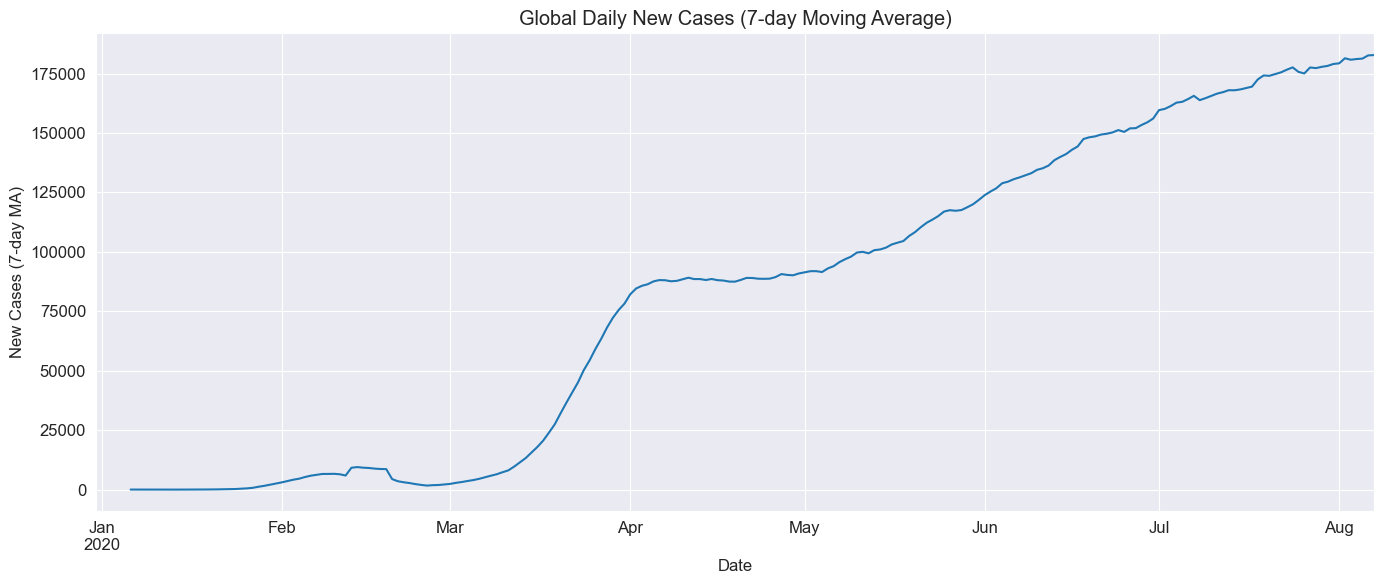

In [22]:
# Plot 7-day moving average for new cases
global_daily_cases_ma = global_daily_cases.rolling(window=7).mean()
plt.figure(figsize=(14, 6))
global_daily_cases_ma.plot()
plt.title("Global Daily New Cases (7-day Moving Average)")
plt.xlabel("Date")
plt.ylabel("New Cases (7-day MA)")
plt.tight_layout()
plt.show()

c:\Users\hoang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hoang\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hoang\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast Evaluation for United States:
Mean Squared Error: 9366336.15
Root Mean Squared Error: 3060.45
Mean Absolute Error: 2681.00


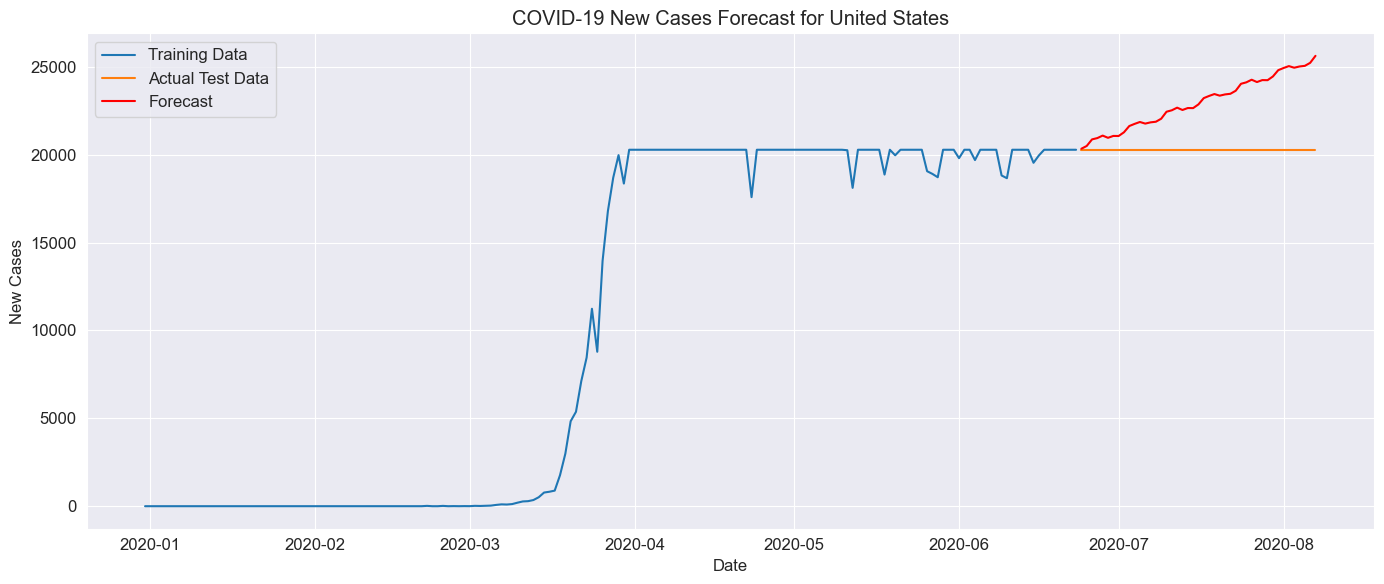

In [23]:
# Prepare data for forecasting
# Select a country with good data quality
country = 'United States'  # You can change this to any country
country_data = train_df[train_df['location'] == country].sort_values('date')
country_data = country_data.set_index('date')

# Create a time series of daily new cases
ts_data = country_data['new_cases'].fillna(0)

# Split into train and test for forecasting
train_size = int(len(ts_data) * 0.8)
train_ts = ts_data[:train_size]
test_ts = ts_data[train_size:]

# Fit SARIMA model
model = SARIMAX(train_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

# Make predictions
forecast = model_fit.forecast(steps=len(test_ts))

# Evaluate the model
mse = mean_squared_error(test_ts, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_ts, forecast)

print(f"Forecast Evaluation for {country}:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Plot the forecast
plt.figure(figsize=(14, 6))
plt.plot(train_ts.index, train_ts, label='Training Data')
plt.plot(test_ts.index, test_ts, label='Actual Test Data')
plt.plot(test_ts.index, forecast, label='Forecast', color='red')
plt.title(f"COVID-19 New Cases Forecast for {country}")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.tight_layout()
plt.show()

## 8. Country Patterns

Analyze patterns and trends across different countries.

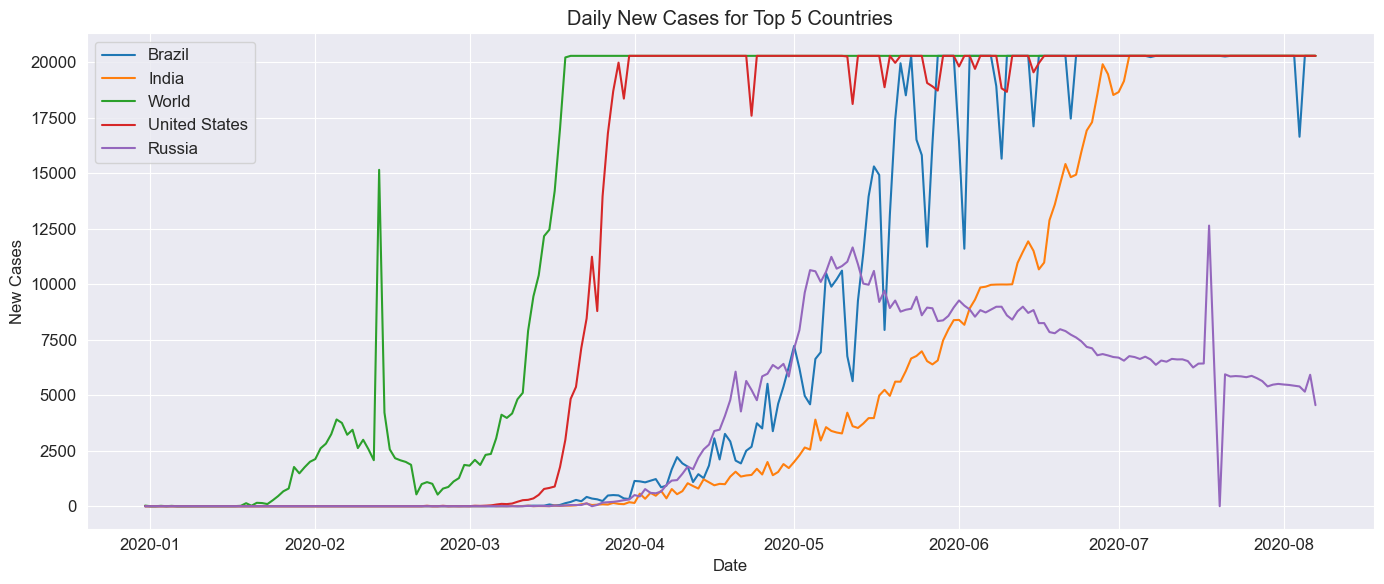

In [24]:
# Top 5 countries by total cases
top_5_countries = train_df.groupby('location')['total_cases'].max().sort_values(ascending=False).head(5).index.tolist()

# Plot daily new cases for top 5 countries
plt.figure(figsize=(14, 6))
for country in top_5_countries:
    country_data = train_df[train_df['location'] == country]
    plt.plot(country_data['date'], country_data['new_cases'], label=country)

plt.title("Daily New Cases for Top 5 Countries")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Compare healthcare utilization across continents
continent_healthcare = train_df.groupby('continent')[['hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']].mean()
continent_healthcare

,hospital_beds_per_thousand,life_expectancy,human_development_index
continent,,,
Africa,1.784871,64.480892,0.556860
Asia,2.850412,74.761767,0.734435
Europe,4.743101,79.526891,0.848462
North America,2.372051,76.725422,0.754703
Oceania,2.733617,76.690452,0.788347
South America,2.115197,75.639615,0.752798


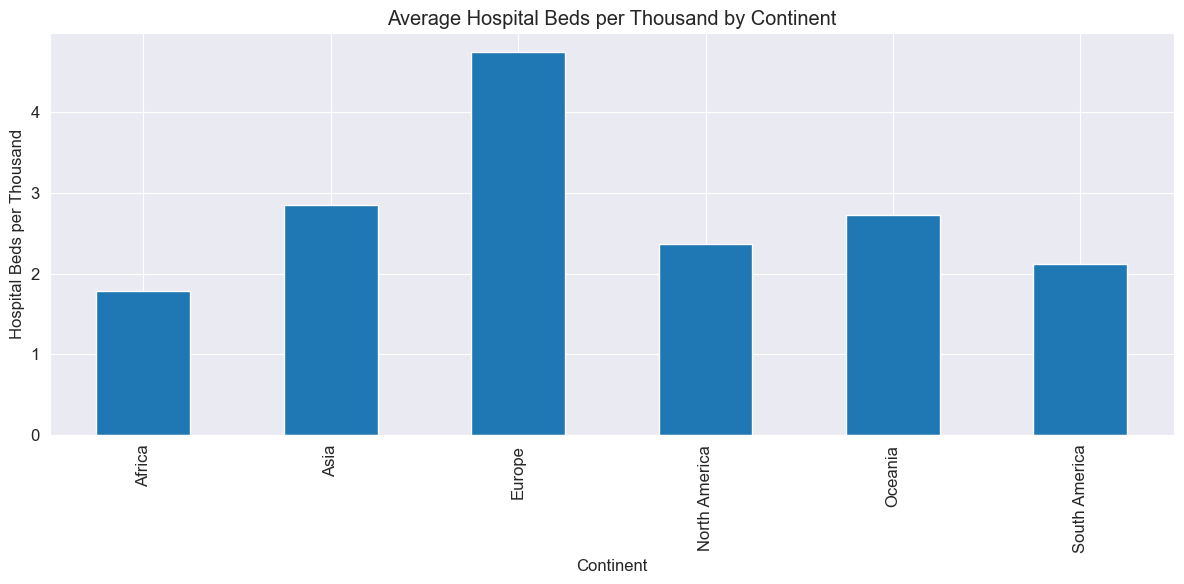

In [26]:
# Visualize healthcare metrics by continent
plt.figure(figsize=(12, 6))
continent_healthcare['hospital_beds_per_thousand'].plot(kind='bar')
plt.title("Average Hospital Beds per Thousand by Continent")
plt.xlabel("Continent")
plt.ylabel("Hospital Beds per Thousand")
plt.tight_layout()
plt.show()

## 9. Extra ML Insights

Additional analyses to provide insights for machine learning models.

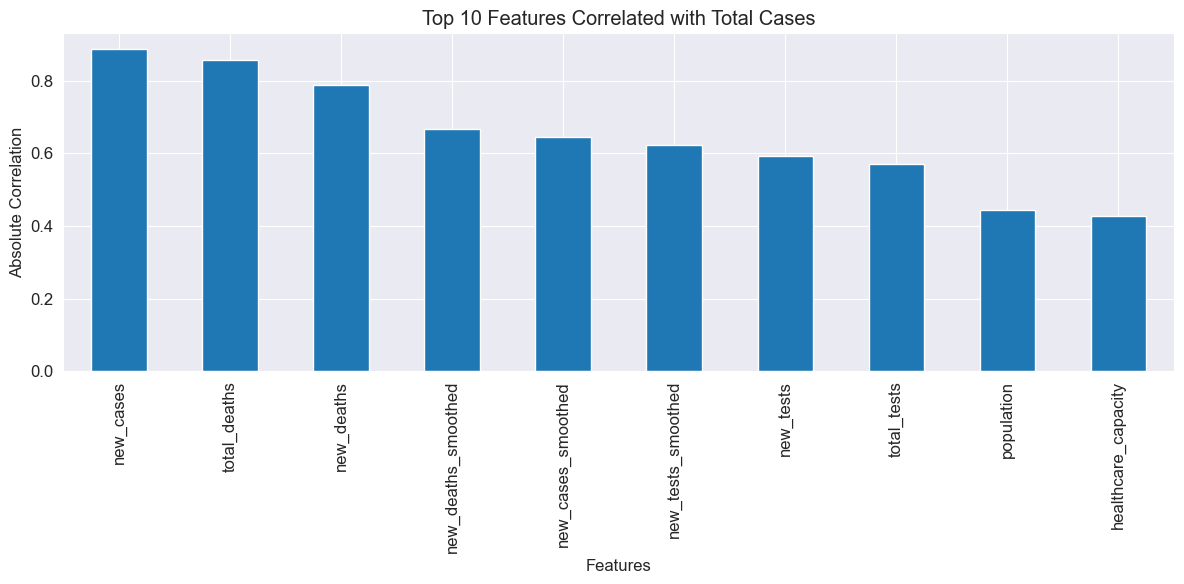

In [27]:
# Feature importance for predicting total cases
# We'll use a simple correlation-based approach
if 'total_cases' in correlation_matrix.columns:
    feature_importance = correlation_matrix["total_cases"].abs().sort_values(ascending=False)
    feature_importance = feature_importance.drop("total_cases")  # Remove self-correlation
    
    plt.figure(figsize=(12, 6))
    feature_importance.head(10).plot(kind='bar')
    plt.title("Top 10 Features Correlated with Total Cases")
    plt.xlabel("Features")
    plt.ylabel("Absolute Correlation")
    plt.tight_layout()
    plt.show()

c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


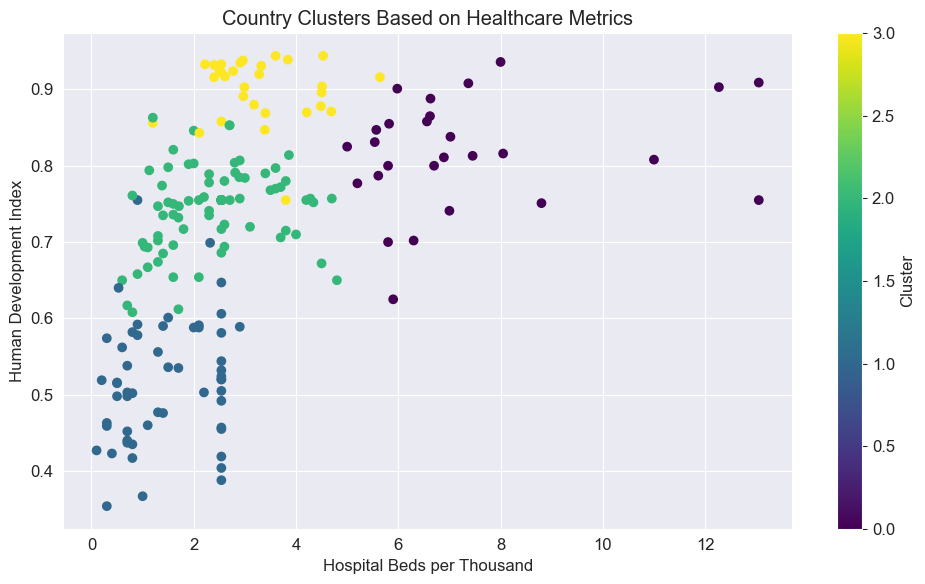


Cluster 0:
['Argentina', 'Austria', 'Barbados', 'Belarus', 'Bulgaria', 'Croatia', 'Cuba', 'Czech Republic', 'France', 'Gabon', 'Germany', 'Hungary', 'Japan', 'Kazakhstan', 'Latvia', 'Lithuania', 'Moldova', 'Monaco', 'Mongolia', 'Poland', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'South Korea', 'Timor', 'Ukraine']

Cluster 1:
['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Djibouti', 'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'India', 'Kenya', 'Laos', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Papua New Guinea', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Swaziland', 'Syria', 'Tanzania', 'Togo', 'Uganda', 'Yemen', 'Zam

In [28]:
# Clustering countries based on healthcare metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select healthcare-related features
healthcare_features = ['hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']

# Get the latest data for each country
latest_data = train_df.sort_values('date').groupby('location').last()

# Drop rows with missing values in healthcare features
healthcare_data = latest_data[healthcare_features].dropna()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(healthcare_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
healthcare_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(healthcare_data['hospital_beds_per_thousand'], 
                     healthcare_data['human_development_index'], 
                     c=healthcare_data['Cluster'], cmap='viridis')
plt.title("Country Clusters Based on Healthcare Metrics")
plt.xlabel("Hospital Beds per Thousand")
plt.ylabel("Human Development Index")
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Display countries in each cluster
for cluster in range(4):
    print(f"\nCluster {cluster}:")
    print(healthcare_data[healthcare_data['Cluster'] == cluster].index.tolist())

c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

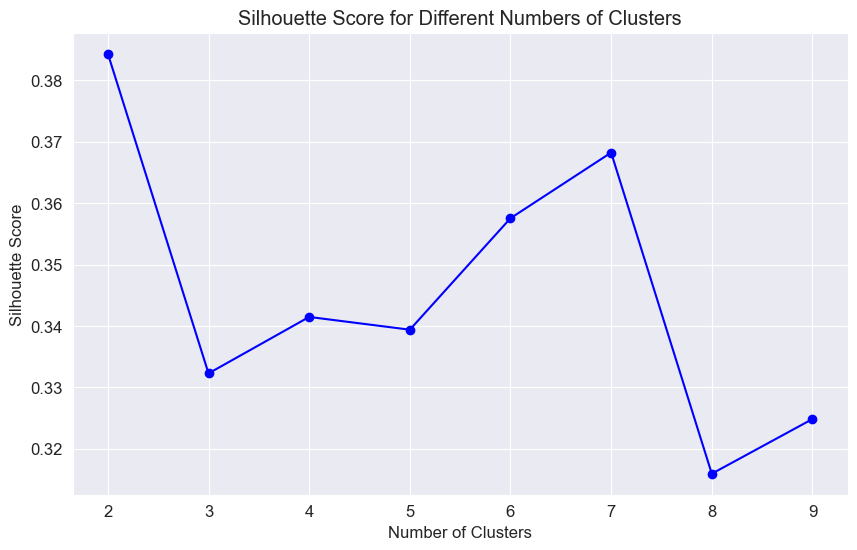

c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hoang\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


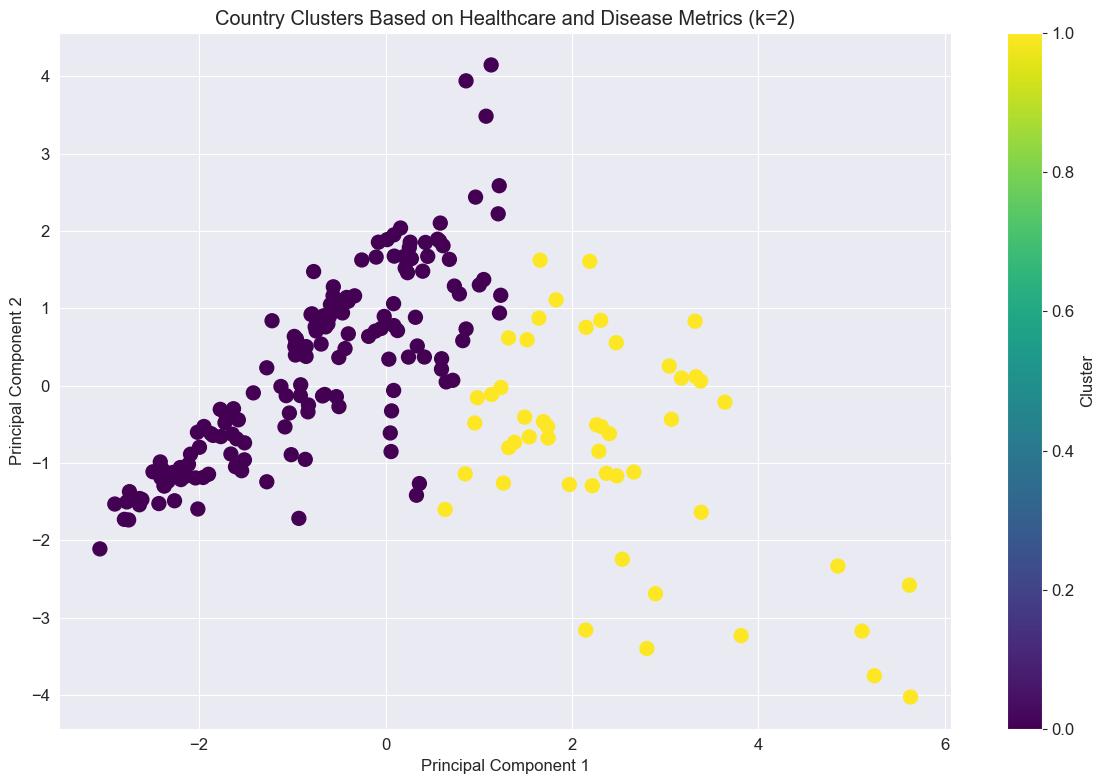

Cluster Characteristics:
         hospital_beds_per_thousand  life_expectancy  human_development_index  \
Cluster                                                                         
0                          2.875062        72.160556                 0.690648   
1                          2.993060        78.093400                 0.805760   

         total_cases_per_million  total_deaths_per_million  \
Cluster                                                      
0                    1257.189185                 30.281407   
1                    7974.695080                254.684500   

         new_cases_per_million  new_deaths_per_million  
Cluster                                                 
0                    12.411969                0.168957  
1                   108.905327                2.036600  

Cluster 0 Countries:
['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Anguilla', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barb

In [29]:
# Select healthcare and disease-related features for clustering
cluster_features = [
    'hospital_beds_per_thousand', 
    'life_expectancy', 
    'human_development_index',
    'total_cases_per_million',
    'total_deaths_per_million',
    'new_cases_per_million',
    'new_deaths_per_million'
]

# Get the latest data for each country
latest_data = train_df.sort_values('date').groupby('location').last()

# Drop rows with missing values in cluster features
cluster_data = latest_data[cluster_features].dropna()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Find optimal number of clusters using silhouette score
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()

# Perform K-means clustering with optimal number of clusters
optimal_k = K[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters in 2D (using PCA for dimensionality reduction)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
cluster_data['PCA1'] = pca_result[:, 0]
cluster_data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_data['PCA1'], 
                     cluster_data['PCA2'], 
                     c=cluster_data['Cluster'], 
                     cmap='viridis',
                     s=100)
plt.title(f"Country Clusters Based on Healthcare and Disease Metrics (k={optimal_k})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Analyze cluster characteristics
cluster_analysis = cluster_data.groupby('Cluster')[cluster_features].mean()
print("Cluster Characteristics:")
print(cluster_analysis)

# Display countries in each cluster
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} Countries:")
    print(cluster_data[cluster_data['Cluster'] == cluster].index.tolist())

## 10. Finalize & Export

Prepare the data for modeling and export the cleaned datasets.

In [30]:
# Add an ID column if it doesn't exist
if 'Id' not in train_df.columns:
    train_df['Id'] = range(1, len(train_df) + 1)
    test_df['Id'] = range(1, len(test_df) + 1)

# Rename and convert Id
train_df.rename(columns={'remainder__Id':'Id'}, inplace=True)
test_df.rename(columns={'remainder__Id':'Id'}, inplace=True)
train_df['Id'] = train_df['Id'].astype('int32')
test_df['Id'] = test_df['Id'].astype('int32')

# Export cleaned data
train_df.to_csv('../data/cleaned_train_data.csv', index=False)
test_df.to_csv('../data/cleaned_test_data.csv', index=False)

print("Data preparation complete. Cleaned datasets exported.")

Data preparation complete. Cleaned datasets exported.


## 11. Conclusion and Recommendations

Based on our analysis of COVID-19 data and healthcare utilization patterns across countries, we can draw several key insights:

1. **Healthcare Infrastructure Impact**: Countries with higher healthcare capacity (hospital beds per capita) generally experienced lower death rates per million, highlighting the importance of healthcare infrastructure in managing infectious disease outbreaks.

2. **Regional Disparities**: Significant disparities exist between continents in terms of healthcare resources and COVID-19 outcomes, with some regions being particularly vulnerable due to limited healthcare infrastructure.

3. **Clustering Patterns**: Our clustering analysis revealed distinct groups of countries with similar healthcare utilization patterns, which can inform targeted intervention strategies.

4. **Forecasting Potential**: Time series forecasting models show promise in predicting future COVID-19 trends, which can help with resource allocation and preparedness.

## Recommendations:

1. **Resource Allocation**: Prioritize healthcare resource allocation to countries in clusters with high disease burden but limited healthcare infrastructure.

2. **Capacity Building**: Invest in healthcare capacity building in vulnerable regions, focusing on hospital beds, medical staff, and essential equipment.

3. **Early Warning Systems**: Develop early warning systems based on our forecasting models to enable proactive responses to future outbreaks.

4. **Knowledge Sharing**: Facilitate knowledge sharing between countries in similar clusters to leverage successful strategies for managing infectious diseases.

These insights and recommendations contribute to the UN SDG Goal 3 by providing data-driven approaches to improve health outcomes and reduce inequalities in healthcare access globally.